In [1]:
import pickle

data_to_load = {
    "X_train": None,
    "X_valid": None,
    "X_test": None,
    "y_train": None,
    "y_valid": None,
    "y_test": None,
    "y_mean": None, 
    "y_std": None,
    "df_test": None
}
for k in data_to_load.keys():
    with open(k + ".pkl", 'rb') as file:
        data_to_load[k] = pickle.load(file)
X_train, X_valid, X_test = data_to_load["X_train"], data_to_load["X_valid"], data_to_load["X_test"]
y_train, y_valid, y_test = data_to_load["y_train"], data_to_load["y_valid"], data_to_load["y_test"]
y_mean, y_std = data_to_load["y_mean"], data_to_load["y_std"]
df_test = data_to_load["df_test"]

[0]	validation_0-rmse:1.06596
[1]	validation_0-rmse:1.05662
[2]	validation_0-rmse:1.04799
[3]	validation_0-rmse:1.04002
[4]	validation_0-rmse:1.03264
[5]	validation_0-rmse:1.02582
[6]	validation_0-rmse:1.01954
[7]	validation_0-rmse:1.01373
[8]	validation_0-rmse:1.00836
[9]	validation_0-rmse:1.00341
[10]	validation_0-rmse:0.99886
[11]	validation_0-rmse:0.99466
[12]	validation_0-rmse:0.99079
[13]	validation_0-rmse:0.98722
[14]	validation_0-rmse:0.98393
[15]	validation_0-rmse:0.98089
[16]	validation_0-rmse:0.97809
[17]	validation_0-rmse:0.97550
[18]	validation_0-rmse:0.97313
[19]	validation_0-rmse:0.97095
[20]	validation_0-rmse:0.96895
[21]	validation_0-rmse:0.96711
[22]	validation_0-rmse:0.96542
[23]	validation_0-rmse:0.96385
[24]	validation_0-rmse:0.96241
[25]	validation_0-rmse:0.96109
[26]	validation_0-rmse:0.95990
[27]	validation_0-rmse:0.95879
[28]	validation_0-rmse:0.95777
[29]	validation_0-rmse:0.95681
[30]	validation_0-rmse:0.95595
[31]	validation_0-rmse:0.95517
[32]	validation_0-

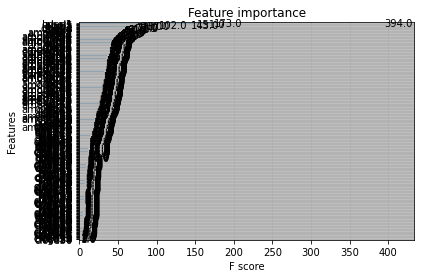

high4      0.010027
low4       0.006742
label1     0.005533
close4     0.005513
label5     0.005197
             ...   
open3      0.001334
open2      0.001231
close34    0.001111
open1      0.000712
low50      0.000000
Length: 367, dtype: float32 

Linear Model Coef:
open32      0.088523
close43     0.068625
close32     0.065975
amount24    0.064866
close40     0.063182
              ...   
high31     -0.072942
open35     -0.075456
low43      -0.083390
high32     -0.087418
high55     -0.088000
Length: 367, dtype: float64


In [2]:
import scutquant.scutquant as q
from scutquant import report, executor

model = q.hybrid()
model.fit(X_train, y_train, X_valid, y_valid)
model.explain_model(index=X_train.columns)

In [3]:
import pandas as pd

pred = model.predict(X_test)
pred = pd.DataFrame(pred, columns=["predict"], index=X_test.index)
pred["predict"] += y_mean
pred["predict"] *= y_std
pred.describe()

,predict
count,281840.000000
mean,-0.000127
std,0.001339
min,-0.034213
25%,-0.000637
50%,0.000037
75%,0.000593
max,0.035548


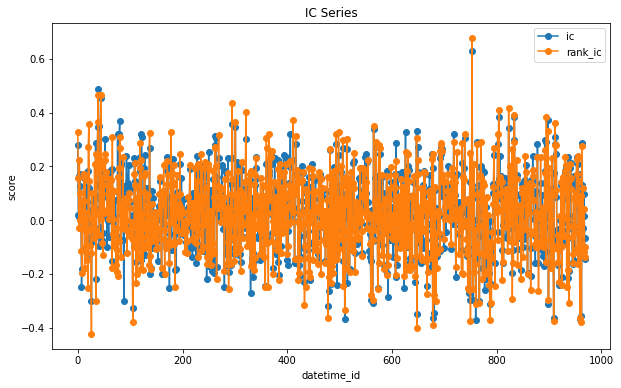

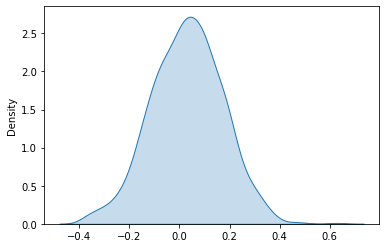

ic= 0.029507302723398347 icir= 0.20634668938336662 rank_ic= 0.023153383583519715 rank_icir= 0.15453845829696564


0.0270266193298547

In [4]:
ic, icir, rank_ic, rank_icir = q.ic_ana(pred["predict"], y_test, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)
# 使用pearson相关系数评判拟合优度
r = q.pearson_corr(pred["predict"].values, y_test)
r

Accuracy of Prediction: 0.5283347430220409


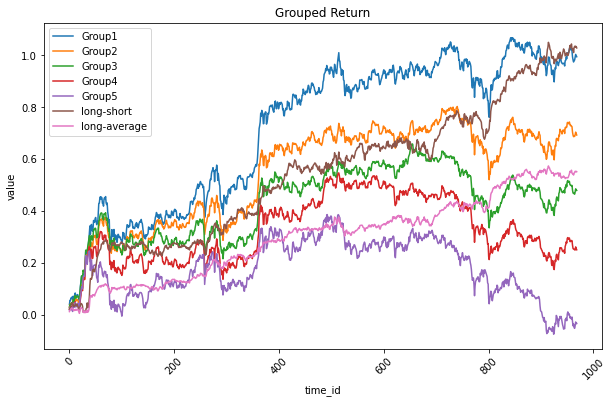

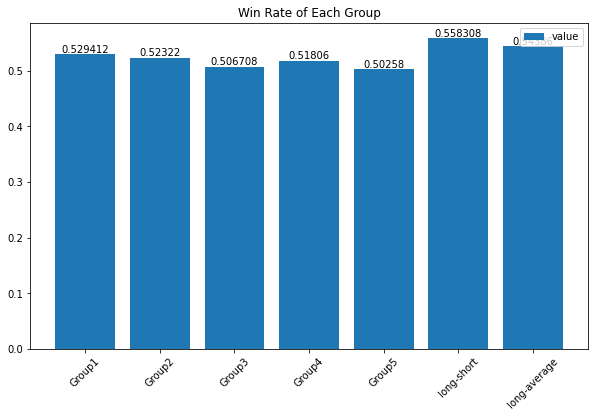

In [5]:
# 将预测值处理成回测需要的格式
pred = executor.prepare(pred, df_test, price='mean_price', volume='vol')
report.group_return_ana(pred, y_test)

In [6]:
backtest = {
    "generator": {
        "mode": "generate"
    },
    "strategy": {
        "class": "TopKStrategy",  # 做多预测值前20%的股票, 做空后20%的股票. 自动平仓
        "kwargs": {
            "auto_offset": True,
            "offset_freq": 2, # 应为delta_t + 1, 例如目标值是close_-2 / close_-1 - 1, 则delta_t = 1
            "buy_only": False,  # =True时，只做多不做空(在A股做空有一定的难度)
            "risk_degree": 0.95,  # 将风险度控制在这个数，如果超过了就按比例减持股票直到风险度小于等于它为止
            "unit": None,  # 由于数据已经是以手为单位, 故无需二次处理
            "max_volume": 0.5  # 手数随可用资金而改变，最大不会超过股票当天成交量的x%(例如T+1时下单，下单手数不会超过T时成交量的x%)
        }
    },
    "account": None,  # 使用默认账户, 即初始资金为1亿, 无底仓
    "trade_params": {
        "cost_buy": 0.0015,  # 佣金加上印花税
        "cost_sell": 0.0005,  
        "min_cost": 5,
    }
}
generator, strategy, account, trade_params = backtest["generator"], backtest["strategy"], backtest["account"], backtest["trade_params"]
exe = executor.Executor(generator, strategy, account, trade_params)
exe.execute(data=pred, verbose=0)

E(r): 0.29001258314885947
std: 0.15699273140232212
E(r_benchmark): 0.4145573363202267
std_benchmark: 0.1728743456410088 

Cumulative Rate of Return: 0.5052923330655739
Cumulative Rate of Return(benchmark): 0.33958556303554865
Cumulative Excess Rate of Return: 0.1657067700300252 

Max Drawdown: -0.06727791351881329
Max Drawdown(benchmark): -0.5462600364770351 

Sharpe Ratio: 1.8467758906941925
Sortino Ratio: -0.9072171348245135
Information Ratio: -0.7933154105854676 

Beta: 0.5947940141210011
Profitable Days(%): 0.19504643962848298


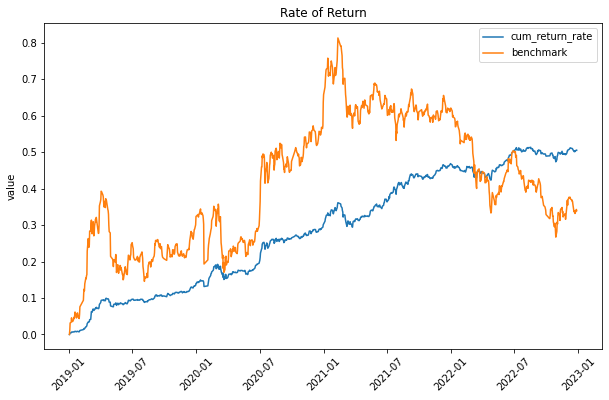

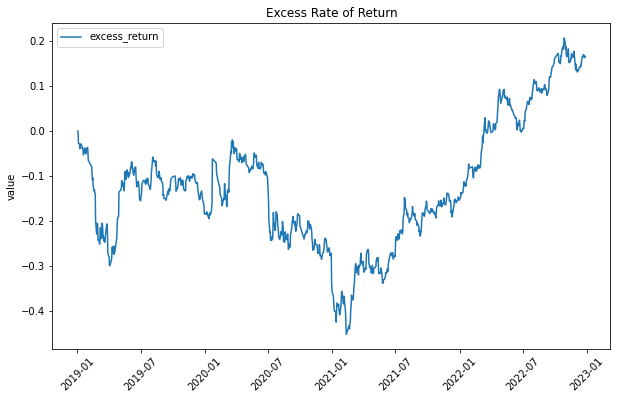

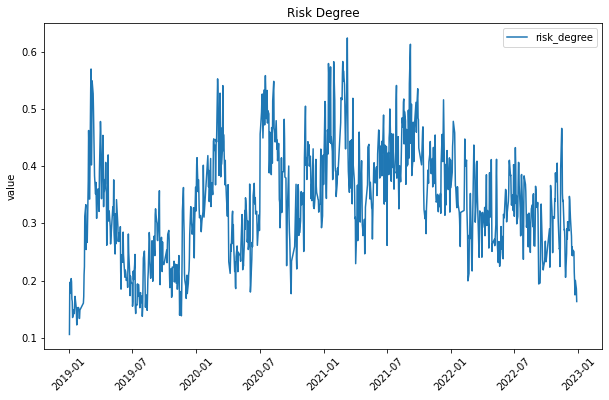

In [7]:
user_account, benchmark = exe.user_account, exe.benchmark
report.report_all(user_account, benchmark, freq=365, time=exe.time)  # 无风险收益率默认为年化3%，可以通过参数rf调节

In [8]:
model.save("./hybrid")